In [1]:
import numpy as np
import matplotlib.pyplot as plt

# add project root folder to path to allow import local modules
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
# import local modules
from helpers import compute_ridge_loss
from helpers import *
from implementations import *
from preprocessing import *

In [2]:
np.random.seed(2020)

## Make custom pipeline to create polynomial expansion of the features

In [3]:
class PolyPreprocessing(Preprocessing):
    def __init__(self,dataset):
        super().__init__(dataset)
        self.degree = None
        self.cross_degree = None
        
    def set_degrees(self,degree, cross_degree):
        self.degree = degree
        self.cross_degree = cross_degree
        
    def _feature_engineering(self):
        super()._feature_engineering() # to create pipeline
        
        dataset =self.dataset
        
        for deg in range(2,self.degree+1):
            self.dataset = np.concatenate((self.dataset, np.power(dataset,deg)),axis=1)
        
        if (self.cross_degree):
            for col_i in range(dataset.shape[1]):
                for col_j in range(col_i+1,dataset.shape[1]):
                    print(col_i)
                    print(col_j)
                    col = dataset[:,col_i]*dataset[:,col_j]
                    self.dataset = np.concatenate((self.dataset,col.reshape((-1,1))),axis=1)

        


## Load Datasets


In [4]:
p_train = PolyPreprocessing(load_csv('../dataset/trainset.csv'))
p_test = PolyPreprocessing(load_csv('../dataset/testset.csv'))


In [5]:
p_train.set_degrees(7,1)
p_test.set_degrees(7,1)
y_train , x_train= p_train.preprocess()
y_test, x_test = p_test.preprocess()

0
1
0
2
0
3
0
4
0
5
0
6
0
7
0
8
0
9
0
10
0
11
0
12
0
13
0
14
0
15
0
16
0
17
0
18
0
19
0
20
0
21
0
22
0
23
0
24
0
25
0
26
0
27
0
28
0
29
1
2
1
3
1
4
1
5
1
6
1
7
1
8
1
9
1
10
1
11
1
12
1
13
1
14
1
15
1
16
1
17
1
18
1
19
1
20
1
21
1
22
1
23
1
24
1
25
1
26
1
27
1
28
1
29
2
3
2
4
2
5
2
6
2
7
2
8
2
9
2
10
2
11
2
12
2
13
2
14
2
15
2
16
2
17
2
18
2
19
2
20
2
21
2
22
2
23
2
24
2
25
2
26
2
27
2
28
2
29
3
4
3
5
3
6
3
7
3
8
3
9
3
10
3
11
3
12
3
13
3
14
3
15
3
16
3
17
3
18
3
19
3
20
3
21
3
22
3
23
3
24
3
25
3
26
3
27
3
28
3
29
4
5
4
6
4
7
4
8
4
9
4
10
4
11
4
12
4
13
4
14
4
15
4
16
4
17
4
18
4
19
4
20
4
21
4
22
4
23
4
24
4
25
4
26
4
27
4
28
4
29
5
6
5
7
5
8
5
9
5
10
5
11
5
12
5
13
5
14
5
15
5
16
5
17
5
18
5
19
5
20
5
21
5
22
5
23
5
24
5
25
5
26
5
27
5
28
5
29
6
7
6
8
6
9
6
10
6
11
6
12
6
13
6
14
6
15
6
16
6
17
6
18
6
19
6
20
6
21
6
22
6
23
6
24
6
25
6
26
6
27
6
28
6
29
7
8
7
9
7
10
7
11
7
12
7
13
7
14
7
15
7
16
7
17
7
18
7
19
7
20
7
21
7
22
7
23
7
24
7
25
7
26
7
27
7
28
7
29
8
9
8
10
8
11
8
12
8
13


In [6]:
print(x_train.shape)
print(x_test.shape)

(225000, 646)
(25000, 646)


## Prediction with decision boundary

In [7]:
def predict(weight, x_test, boundary = 0.5):
    """
    # Gives predictions given weight and datapoints 
    
    :param weight: vector weight
    :type weight: 1D array
    
    :param x_test: extended feature matrix
    :type x_test: 2D array
    
    :return: label predictions (0 or 1)
    :rtype:  1D numpy array
    
    """
    
    pred = x_test.dot(weight)
    return (pred > boundary)*1
    

## Ridge Regression on dataset

In [8]:
w, loss = ridge_regression(y_train, x_train,0.004)
#print(w) # gives an idea about the important columns.. 
print(loss)

0.0693874115443339


##  Cross Validation

In [9]:
def build_k_indices(y, k_fold):
    """build k indices for k-fold."""
    num_row = y.shape[0]
    interval = int(num_row / k_fold)
    indices = np.random.permutation(num_row)
    k_indices = [indices[k * interval: (k + 1) * interval]
                 for k in range(k_fold)]
    return np.array(k_indices)

def K_Cross_Validation(x, y, K, _lambda):
    #Initialization of all needed arrays
    test_loss = np.zeros(K)
    train_loss = np.zeros(K)
    weights = np.zeros((K,x.shape[1]))
    accuracy = np.zeros(K)
    indices = build_k_indices(y, K)
    
    for i in range(K):
        test_indices = indices[i]
        y_test = y[test_indices]
        y_train = np.delete(y,test_indices)
        x_test = x[test_indices,:]
        x_train = np.delete(x,test_indices,axis=0)

        ### ADAPT METHOD & LOSS
        weights[i], train_loss[i] = ridge_regression(y_train, x_train,_lambda)
        test_loss[i] = compute_ridge_loss(y_test,x_test,weights[i],_lambda)
        
        #Calculate predictions of the model
        predictions = predict(weights[i] , x_test)
        #Calculate accuracy of the model
        accuracy[i] = np.sum(predictions == y_test) / len(y_test)
        
    return accuracy, test_loss, train_loss, np.mean(weights, axis=0)
        

0.8164355555555556


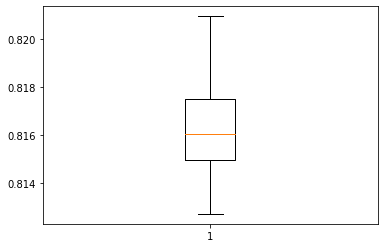

In [10]:
accs,test_loss, train_loss, w = K_Cross_Validation(x_train,y_train,4,0.001)
plt.boxplot(accs)
print(accs.mean())

## Tune Hyperparameters

In [22]:
def Tune_lambda(xt_training, y_training, K, gamma_range):
        
    gammas = np.logspace(-7, gamma_range, 20)
    max_acc = 0
    opt_lambda = 0
    accuracies = []
    train_losses = []
    test_losses = []
    for i, gamma in enumerate(gammas):
       
        accuracy,test,train,w = K_Cross_Validation(xt_training, y_training, K,gamma)
        accuracies.append([gamma,accuracy.mean()])
        train_losses.append([gamma,train.mean()])
        test_losses.append([gamma,test.mean()])
        if (accuracy.mean() > max_acc):
            max_acc = accuracy.mean()
            opt_gamma = gamma
                
    return opt_gamma , max_acc, np.array(accuracies), np.array(train_losses), np.array(test_losses)
opt_lambda, max_acc, acc ,train, test= Tune_lambda(x_train, y_train, 5, 1)

print(f"optimal acc = {max_acc} with lambda= {opt_lambda}")

optimal acc = 0.8170488888888888 with lambda= 1.274274985703132e-05


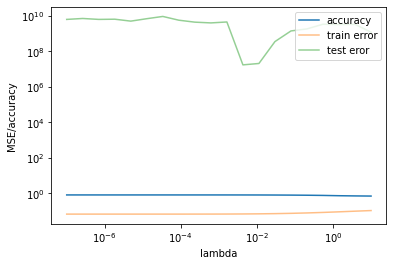

In [23]:

plt.plot(acc[:,0],acc[:,1], label="accuracy")
plt.plot(train[:,0],train[:,1],alpha=0.5,label="train error")
plt.plot(test[:,0],test[:,1],alpha=0.5, label = "test eror")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("lambda")
plt.ylabel("MSE/accuracy")
plt.legend(loc="upper right")
plt.show()

model is clearly overfitting, needs to be fixed

## predictions on test set 

In [36]:
w_opt,loss = ridge_regression(y_train,x_train,0.0001)
p = predict(w_opt,x_test)
print((p==y_test).mean())

0.81584


## create submission file


In [26]:
p = PolyPreprocessing(load_csv('../dataset/test.csv'))
p.set_degrees(7,1)
ids, tx = p.preprocess(labeled=False)

prediction data
0
1
0
2
0
3
0
4
0
5
0
6
0
7
0
8
0
9
0
10
0
11
0
12
0
13
0
14
0
15
0
16
0
17
0
18
0
19
0
20
0
21
0
22
0
23
0
24
0
25
0
26
0
27
0
28
0
29
1
2
1
3
1
4
1
5
1
6
1
7
1
8
1
9
1
10
1
11
1
12
1
13
1
14
1
15
1
16
1
17
1
18
1
19
1
20
1
21
1
22
1
23
1
24
1
25
1
26
1
27
1
28
1
29
2
3
2
4
2
5
2
6
2
7
2
8
2
9
2
10
2
11
2
12
2
13
2
14
2
15
2
16
2
17
2
18
2
19
2
20
2
21
2
22
2
23
2
24
2
25
2
26
2
27
2
28
2
29
3
4
3
5
3
6
3
7
3
8
3
9
3
10
3
11
3
12
3
13
3
14
3
15
3
16
3
17
3
18
3
19
3
20
3
21
3
22
3
23
3
24
3
25
3
26
3
27
3
28
3
29
4
5
4
6
4
7
4
8
4
9
4
10
4
11
4
12
4
13
4
14
4
15
4
16
4
17
4
18
4
19
4
20
4
21
4
22
4
23
4
24
4
25
4
26
4
27
4
28
4
29
5
6
5
7
5
8
5
9
5
10
5
11
5
12
5
13
5
14
5
15
5
16
5
17
5
18
5
19
5
20
5
21
5
22
5
23
5
24
5
25
5
26
5
27
5
28
5
29
6
7
6
8
6
9
6
10
6
11
6
12
6
13
6
14
6
15
6
16
6
17
6
18
6
19
6
20
6
21
6
22
6
23
6
24
6
25
6
26
6
27
6
28
6
29
7
8
7
9
7
10
7
11
7
12
7
13
7
14
7
15
7
16
7
17
7
18
7
19
7
20
7
21
7
22
7
23
7
24
7
25
7
26
7
27
7
28
7
29
8
9
8
10

In [27]:
p = predict(w_opt,tx)


In [28]:
create_csv_submission(ids, p, "model_0003_deg71.csv")

## store dataset in pickle


In [30]:
import pickle
pickle.dump( x_train, open( "0003_x_train.p", "wb" ) )
pickle.dump( x_test, open( "0003_x_test.p", "wb" ) )
pickle.dump( y_train, open( "0003_y_train.p", "wb" ) )
pickle.dump( y_test, open( "0003_y_test.p", "wb" ) )
pickle.dump( tx, open("0003_x_predict.p","wb"))

